In [1]:
import matplotlib.pyplot as plt
import pandas
import numpy
import rba
import seaborn

from matplotlib.gridspec import GridSpec
from rbatools.rba_session import SessionRBA


# Generate data

In [2]:
model_filename = '../../Bacterial-RBA-models/Bacillus-subtilis-168-WT'
Simulation = SessionRBA(model_filename,lp_solver="cplex")
Simulation.add_exchange_reactions()


## Glucose screen

In [3]:
Simulation.reload_model()
glcs=[0.005,0.0075,0.01,0.0125,0.015,0.0175,0.02]+[0.02+((i+1)*0.0005) for i in range(20)]+[0.03+((i+1)*0.0025) for i in range(18)]
#glcs=[0.025,0.0125]
Results_glc_screen={"Mu":[],"M_glc":[],"M_o2":[],"M_ac":[],"P_TA_machinery":[],"Eatp_enzyme":[]}
for glc_conc in glcs:
    Simulation.set_medium({'M_glc':glc_conc})
    mumax=Simulation.find_max_growth_rate(max=1.0,start_value=0.3)
    J_ex=Simulation.return_exchange_fluxes()
    for i in Results_glc_screen.keys():
        if i =="Mu":
            Results_glc_screen["Mu"].append(mumax)
        else:
            if i in J_ex.keys():
                Results_glc_screen[i].append(J_ex[i])
            elif i in Simulation.Problem.SolutionValues.keys():
                Results_glc_screen[i].append(Simulation.Problem.SolutionValues[i])
            else:
                Results_glc_screen[i].append(0)

In [4]:
glc_WT=abs(Results_glc_screen['M_glc'][glcs.index(0.025)])
mu_WT=abs(Results_glc_screen['Mu'][glcs.index(0.025)])
o2_WT=abs(Results_glc_screen['M_o2'][glcs.index(0.025)])
ac_WT=abs(Results_glc_screen['M_ac'][glcs.index(0.025)])
P_TA_WT=abs(Results_glc_screen['P_TA_machinery'][glcs.index(0.025)])
Eatp_enzyme_WT=abs(Results_glc_screen['Eatp_enzyme'][glcs.index(0.025)])

glc_WT_0125=abs(Results_glc_screen['M_glc'][glcs.index(0.0125)])
mu_WT_0125=abs(Results_glc_screen['Mu'][glcs.index(0.0125)])
o2_WT_0125=abs(Results_glc_screen['M_o2'][glcs.index(0.0125)])
ac_WT_0125=abs(Results_glc_screen['M_ac'][glcs.index(0.0125)])
P_TA_0125=abs(Results_glc_screen['P_TA_machinery'][glcs.index(0.0125)])
Eatp_enzyme_0125=abs(Results_glc_screen['Eatp_enzyme'][glcs.index(0.0125)])


## RVA

In [5]:
Simulation.reload_model()

Simulation.set_medium({'M_glc':0.0125})
maxmu_0125=Simulation.find_max_growth_rate()
Mus_RVA_0125=[maxmu_0125*i for i in [0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5,0.525,0.55,0.575,0.6,0.625,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,0.9825,0.99,0.9925,0.995,0.9975,1]]
Reactions_to_check=["R_EX_glc_e","R_EX_o2_e","R_EX_ac_e","P_TA_machinery","Eatp_enzyme"]
Feasible_Ranges_0125=dict(zip(Reactions_to_check,[{"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]}]))

for mu in Mus_RVA_0125:
    Simulation.set_growth_rate(mu)
    Feasible_range=Simulation.get_feasible_range(variables=Reactions_to_check)
    for rxn in Reactions_to_check:
        Feasible_Ranges_0125[rxn]["Minima"].append(Feasible_range[rxn]['Min'])
        Feasible_Ranges_0125[rxn]["Maxima"].append(Feasible_range[rxn]['Max'])


In [6]:
Simulation.reload_model()

Simulation.set_medium({'M_glc':0.025})
Mus_RVA=[mu_WT*i for i in [0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5,0.525,0.55,0.575,0.6,0.625,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,0.9825,0.99,0.9925,0.995,0.9975,1]]
Reactions_to_check=["R_EX_glc_e","R_EX_o2_e","R_EX_ac_e","P_TA_machinery","Eatp_enzyme"]
Feasible_Ranges=dict(zip(Reactions_to_check,[{"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]},
                                             {"Minima":[],"Maxima":[]}]))

for mu in Mus_RVA:
    Simulation.set_growth_rate(mu)
    Feasible_range=Simulation.get_feasible_range(variables=Reactions_to_check)
    for rxn in Reactions_to_check:
        Feasible_Ranges[rxn]["Minima"].append(Feasible_range[rxn]['Min'])
        Feasible_Ranges[rxn]["Maxima"].append(Feasible_range[rxn]['Max'])
        

## Kapp sampling

In [7]:
#Simulation.reload_model()

#enzymes=Simulation.add_parameter_multipliers_for_enzyme_efficiencies()
#Simulation.set_medium({'M_glc':0.025})
#KappScreenResults=Simulation.sample_kapp_multipliers(n=1000,mean=0,stdev=numpy.log(1.1),enzymes=enzymes,Variables_to_record=["R_EX_o2_e"],wt_growth_rate=mu_WT)
#df=pandas.DataFrame(KappScreenResults)
#df.to_csv("../../RBAtools_FigSamples_stdevlog_0.1.csv")


In [8]:
sampling_results=pandas.read_csv("../../RBAtools_FigSamples_stdevlog_0.1.csv",index_col=0)

## Pareto

In [9]:
Simulation.reload_model()
# generate process object:
test_process=rba.xml.processes.Process(id_="P_Dummy_Cytosol", 
                                       name="Dummy_process_Cytosol")
# define machinery composition of added process:
test_process.machinery.machinery_composition.reactants._elements.append(
    rba.xml.common.SpeciesReference(species="average_protein_Cytoplasm",
                                    stoichiometry=1))
# add process to model:
Simulation.model.processes.processes.append(test_process)
# determine total number of peptides of protein, constituting machinery
process_machinery_amino_acid_length=sum(list(Simulation.get_protein_information("average_protein_Cytoplasm")['AAcomposition'].values()))

Simulation.rebuild_from_model()


In [10]:
Simulation.set_medium({'M_glc':0.025}) #set glucose concentration

mumax_WT = Simulation.find_max_growth_rate() #determine maximum growth-rate
#create list of various growth-rates between 0 and the maximum:
Growth_rates = [mumax_WT*i for i in [0.001,0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99,1]]
Results_Pareto = {"Protein":[],"ATP":[],"ATP_net":[],"Growth-rate":[],"Protein_concentration":[]} #create empty data-structure for results
total_AAconcentrations = {} #create empty data structure for total amino-acid concentration
atp_maintenance = {} #create empty data structure for total amino-acid concentration
for mu in Growth_rates: #iterate over growth-rates
    Simulation.set_growth_rate(mu) #set growth rate
    #determine current total number of amino acid residues in cell:
    total_AAconcentrations[mu/mumax_WT] = Simulation.get_current_parameter_value(parameter="amino_acid_concentration")
    atp_maintenance[mu/mumax_WT] = Simulation.get_current_parameter_value(parameter="maintenance_atp")
    # calculate pareto front between variables of interest:
    ParetoFront = Simulation.get_pareto_front(variable_X="P_Dummy_Cytosol_machinery", 
                                              variable_Y="R_maintenance_atp", 
                                              N=100, 
                                              sign_VY='max')
    # append fraction of maximum growth rate to results
    Results_Pareto["Growth-rate"].append([int(100*mu/mumax_WT)]*ParetoFront.shape[0])
    # append atp values of pareto front to results
    Results_Pareto["ATP"].append(list(ParetoFront["R_maintenance_atp"]))
    Results_Pareto["ATP_net"].append([i-atp_maintenance[mu/mumax_WT] for i in ParetoFront["R_maintenance_atp"]])
    # append proteome-fraction of protein (number of AAs in protein, divided by total cellular number of AAs)
    Results_Pareto["Protein"].append(list(ParetoFront["P_Dummy_Cytosol_machinery"]*process_machinery_amino_acid_length/total_AAconcentrations[mu/mumax_WT]))
    Results_Pareto["Protein_concentration"].append(list(ParetoFront["P_Dummy_Cytosol_machinery"]))


## Metabolite production

In [11]:
Simulation.reload_model()
Simulation.add_reaction(reaction_id="R_rxnTest", 
                        reactants={"M_tpp_c":1}, reversible=False)


In [12]:
Glucose_concentrations = [0.0125,0.025,0.05,0.1] # generate list of glucose concentrations to test
Growth_rates = {} #create empty data structure for obtained growth rates
excretion_fluxes = {} #create empty data structure for metabolite excretion
for glc_conc in Glucose_concentrations: # iterate over glucose concentration
    excretion_fluxes[glc_conc] = [] #generate empty list for excretion fluxes
    Simulation.set_medium({'M_glc':glc_conc}) # set glucose concentration
    mu_max = Simulation.find_max_growth_rate() #determine wild-type max growth-rate
    #create list of various growth-rates between 0 and the maximum:
    Growth_rates[glc_conc] = [mu_max*i for i in [0.01,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25,0.275,0.3,0.325,0.35,0.375,0.4,0.425,0.45,0.475,0.5,0.525,0.55,0.575,0.6,0.625,0.65,0.675,0.7,0.725,0.75,0.775,0.8,0.825,0.85,0.875,0.9,0.925,0.95,0.975,0.9825,0.99,0.9925,0.995,0.9975,1]]
    for mu in Growth_rates[glc_conc]: #iterate over growth rates
        Simulation.set_growth_rate(mu) #set growth rate
        Simulation.Problem.clear_objective() #clear objective function
        Simulation.Problem.set_objective(inputDict={"R_rxnTest": -1.0}) #specify objective to maximize "R_rxnTest"
        Simulation.Problem.solve_lp() #solve linear problem
        if Simulation.Problem.Solved: # if feasible solution does exist
            #add optimum to results
            excretion_fluxes[glc_conc].append(-Simulation.Problem.ObjectiveValue)
        else:
            excretion_fluxes[glc_conc].append(numpy.nan)     
biotech_application_results={'Growth_rates':Growth_rates,'Excretion_fluxes':excretion_fluxes}

## Ribosome efficiency sampling

In [13]:
Simulation.reload_model()
Glucose_concentrations_ribosome_efficiency_sampling = [0.0125,0.025,0.05,0.1] # generate list of glucose concentrations to test
# add parameter multiplier for ribosome capacity (initialized as 1.0):
Simulation.add_parameter_multiplier(model_parameter="ribosome_capacity", rebuild_model=True)
log_factors = [-2,-1.75,-1.5,-1.25,-1,-0.75,-0.5,-0.375,-0.25,-0.1875,-0.125,-0.0625,0,0.0625,0.125,0.1875,0.25,0.375,0.5,0.75,1,1.25,1.5,1.75,2] # define (logarithmic, base 10) multipliers to test

Ribosome_efficiency_sampling={} # initiate empty result-storing structure
for glc_conc in Glucose_concentrations_ribosome_efficiency_sampling: # iterate over glucose concentrations
    Simulation.set_medium({'M_glc':glc_conc}) # set glucose concentration in medium
    # screen the defined multipliers:
    screen_results = Simulation.screen_multipliers(parameter="ribosome_capacity", 
                                                 factors=[10**i for i in log_factors])
    # store results:
    scaling_factors , growth_rates = [list(i) for i in zip(*screen_results.items())]
    Ribosome_efficiency_sampling[glc_conc] = {"Scaling Factors":scaling_factors,"Growth_rates":[i["Mu"] for i in growth_rates]}


## Local sensitivity

In [14]:
all_enzyme_efficiencies=list(set([Simulation.get_enzyme_constraint_information(i)['CapacityParameterID'] for i in Simulation.get_enzyme_constraints()]))
all_enzymes=list(set([Simulation.get_enzyme_constraint_information(i)['AssociatedEnzyme'] for i in Simulation.get_enzyme_constraints()]))
print("Total - Enzymes: {} - Parameters: {}".format(len(all_enzymes),len(all_enzyme_efficiencies)))

Total - Enzymes: 587 - Parameters: 1174


In [15]:
#Simulation.reload_model()
#Simulation.set_medium({'M_glc':0.025}) # set glucose concentration in medium
#Local_sensitivities_enzymes = Simulation.local_sensitivity(parameters=all_enzyme_efficiencies,
#                                                   relative_parameter_difference=0.01)
#Local_sensitivities_enzymes.to_csv('LocalSensitivities_all_enzymes_1percent.csv')

In [16]:
Local_sensitivities_001=pandas.read_csv("LocalSensitivities_all_enzymes_1percent.csv",index_col=0)

# Defining plotting functions

In [64]:
def plot_glc_screen(ax,input_data,glucose_concentrations):
    ax2=ax.twinx()
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_glc"]],linewidth=3,color=glucose_color,linestyle=(0, (3, 1, 1, 1)),alpha=1,label="$Glucose$ uptake", zorder=1)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_o2"]],linewidth=3,color=oxygen_color,linestyle=(0, (1, 1)),alpha=1,label="$O_2$ uptake", zorder=1)
    ax2.plot(glucose_concentrations,[i for i in input_data["M_ac"]],linewidth=3,color=acetate_color,alpha=1,label="$Acetate$ excretion", zorder=1)
    ax.plot(glucose_concentrations,input_data["Mu"],linewidth=4,alpha=1,color=contrast_line_color,label="Growth rate", zorder=1)

    ax.legend(loc="center right",frameon=False,fontsize=annotation_fontsize,bbox_to_anchor=(0.91, 0.4),labelspacing=0.3)
    ax2.legend(loc="lower right",fontsize=annotation_fontsize,frameon=False,labelspacing=0.3)

    ax2.plot(glucose_concentrations,[i for i in input_data["M_ac"]],linewidth=6,color='white',alpha=1,label="$Acetate$ excretion", zorder=1)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_o2"]],linewidth=6,color='white',alpha=1,label="$O_2$ uptake", zorder=1)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_glc"]],linewidth=6,color='white',alpha=1,label="$Glucose$ uptake", zorder=1)
    ax.plot(glucose_concentrations,input_data["Mu"],linewidth=7,alpha=1,color='white',label="Growth rate", zorder=1)

    ax.axvline(0.025,color=contrast_line_color,linestyle="dashed",alpha=0.7,linewidth=2, zorder=1)

    ax2.plot(glucose_concentrations,[i for i in input_data["M_ac"]],linewidth=4,color='white',alpha=1,label="$Acetate$ excretion", zorder=2)
    ax2.plot(glucose_concentrations,[i for i in input_data["M_ac"]],linewidth=4,color=acetate_color,alpha=1,label="$Acetate$ excretion", zorder=2)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_o2"]],linewidth=4,color='white',alpha=1,label="$O_2$ uptake", zorder=2)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_o2"]],linewidth=4,color=oxygen_color,alpha=1,label="$O_2$ uptake",linestyle=(0, (1, 1)), zorder=2)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_glc"]],linewidth=4,color='white',alpha=1,label="$Glucose$ uptake", zorder=2)
    ax2.plot(glucose_concentrations,[-i for i in input_data["M_glc"]],linewidth=4,color=glucose_color,alpha=1,label="$Glucose$ uptake",linestyle=(0, (3, 1, 1, 1)), zorder=2)

    ax.plot(glucose_concentrations,input_data["Mu"],linewidth=5,alpha=1,color=contrast_line_color,label="Growth rate", zorder=3)
    
    ax.set_title("Glucose screen: cellular states",fontsize=title_font_size)
    ax2.set_xlabel("Glucose concentration [$mM$]",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_xlabel("Glucose concentration [$mM$]",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_ylim(-0.01,0.69)
    ax.set_xlim(0.004,0.069)
    ax.tick_params(axis='y', labelcolor=contrast_line_color)
    
    ax2.tick_params(axis='y', labelcolor=growth_rate_color)
    ax.set_ylabel("Growth rate [$h^{-1}$]",color=contrast_line_color,fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax2.set_ylabel('Fluxes [mmol (h $g_{DW}$)$^{-1}$]',color=growth_rate_color,fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax2.set_ylim(-0.2,15.6)
    ax.set_yticks([0.1,0.2,0.3,0.4,0.5,0.6])
    ax.set_yticklabels([0.1,0.2,0.3,0.4,0.5,0.6],rotation=90,va='center',fontsize=ticklabel_fontsize)
    ax.set_xticks([0.01,0.02,0.03,0.04,0.05,0.06,0.07])
    ax.set_xticklabels([0.01,0.02,0.03,0.04,0.05,0.06,0.07],fontsize=ticklabel_fontsize)
    ax2.set_yticks([2,4,6,8,10,12,14])
    ax2.set_yticklabels([2,4,6,8,10,12,14],fontsize=ticklabel_fontsize)
    

In [65]:
def plot_RVA(ax,input_data,mu_WT,o2_WT,glc_WT,growth_rates):
    ax.axvline(1,color=contrast_line_color,linestyle="dashed",linewidth=2, zorder=1)
    ax.fill_between(x=[i/mu_WT for i in growth_rates],y1=input_data["R_EX_glc_e"]["Minima"],y2=input_data["R_EX_glc_e"]["Maxima"],interpolate=True,color=glucose_color,alpha=0.4, zorder=2)
    ax.plot([i/mu_WT for i in growth_rates],input_data["R_EX_glc_e"]["Minima"],color=glucose_color,alpha=1,linewidth=2, zorder=2)
    ax.plot([i/mu_WT for i in growth_rates],input_data["R_EX_glc_e"]["Maxima"],color=glucose_color,alpha=1,linewidth=2, zorder=2)
    if glc_WT is not None:
        ax.scatter([1],[glc_WT],color=glucose_color,s=50, zorder=3)

    ax2=ax.twinx()
    ax2.fill_between(x=[i/mu_WT for i in growth_rates],y1=input_data["R_EX_o2_e"]["Minima"],y2=input_data["R_EX_o2_e"]["Maxima"],interpolate=True,color=oxygen_color,alpha=0.3, zorder=2)
    ax2.plot([i/mu_WT for i in growth_rates],input_data["R_EX_o2_e"]["Minima"],color=oxygen_color,alpha=1,linewidth=2, zorder=2)
    ax2.plot([i/mu_WT for i in growth_rates],input_data["R_EX_o2_e"]["Maxima"],color=oxygen_color,alpha=1,linewidth=2, zorder=2)
    if o2_WT is not None:
        ax2.scatter([1],[o2_WT],color=oxygen_color,s=50, zorder=3)

    ax.tick_params(axis='y', labelcolor=glucose_color)
    ax2.tick_params(axis='y', labelcolor=oxygen_color)

    ax.set_xlim(0,1.05)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=ticklabel_fontsize)

    ax.set_ylabel('$Glucose$ [mmol (h $g_{DW}$)$^{-1}$]',color=glucose_color,fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax2.set_ylabel('$O_2$ [mmol (h $g_{DW}$)$^{-1}$]',color=oxygen_color,fontsize=axislabel_fontsize,labelpad=labelpad_axislables)

    plt.title('Feasible uptake rates',fontsize=title_font_size)
    ax.set_xlabel('Relative fitness',fontsize=axislabel_fontsize,labelpad=labelpad_axislables)


In [66]:
def plot_RVA_machinery(ax,input_data,mu_WT,P_TA_machinery_WT,Eatp_enzyme_WT,growth_rates):
    ax.axvline(1,color=contrast_line_color,linestyle="dashed",linewidth=2, zorder=1)
    ax.fill_between(x=[i/mu_WT for i in growth_rates],y1=input_data["P_TA_machinery"]["Minima"],y2=input_data["P_TA_machinery"]["Maxima"],interpolate=True,color=dark_mud,alpha=0.35, zorder=2)
    ax.plot([i/mu_WT for i in growth_rates],input_data["P_TA_machinery"]["Minima"],color=dark_mud,alpha=1,linewidth=1, zorder=2)
    ax.plot([i/mu_WT for i in growth_rates],input_data["P_TA_machinery"]["Maxima"],color=dark_mud,alpha=1,linewidth=1, zorder=2)
    if P_TA_machinery_WT is not None:
        ax.scatter([1],[P_TA_machinery_WT],color=dark_mud,s=50, zorder=3)

    ax2=ax.twinx()
    ax2.fill_between(x=[i/mu_WT for i in growth_rates],y1=input_data["Eatp_enzyme"]["Minima"],y2=input_data["Eatp_enzyme"]["Maxima"],interpolate=True,color="#324B4A",alpha=0.2, zorder=1)
    ax2.plot([i/mu_WT for i in growth_rates],input_data["Eatp_enzyme"]["Minima"],color="#324B4A",alpha=1,linewidth=1, zorder=1)
    ax2.plot([i/mu_WT for i in growth_rates],input_data["Eatp_enzyme"]["Maxima"],color="#324B4A",alpha=1,linewidth=1, zorder=1)
    if Eatp_enzyme_WT is not None:
        ax2.scatter([1],[Eatp_enzyme_WT],color="#324B4A",s=50, zorder=2)

    ax.tick_params(axis='y', labelcolor=dark_mud)
    ax2.tick_params(axis='y', labelcolor="#324B4A")

    ax.set_xlim(0,1.05)
    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=ticklabel_fontsize)

    ax.set_ylabel('Ribosomes [mmol / $g_{DW}$]',color=dark_mud,fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax2.set_ylabel('ATP synthase [mmol / $g_{DW}$]',color="#324B4A",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)

    plt.title('Feasible machinery concentrations',fontsize=title_font_size)
    ax.set_xlabel('Relative fitness',fontsize=axislabel_fontsize,labelpad=labelpad_axislables)


In [67]:
def plot_kapp_sampling_mu(ax,input_data,mu_WT):
    seaborn.histplot(data=input_data.loc[(input_data["Mu"]!=4)&(input_data["Mu"]!=None)], 
                     x="Mu",
                     ax=ax,
                     alpha=0.3,
                     linewidth=0,
                     color=contrast_line_color, 
                     kde=True,
                     line_kws={"linewidth":4,"alpha":1,"color":"blue"},
                     bins=17,
                     fill=True, zorder=1)
    if mu_WT is not None:
        ax.axvline(mu_WT,color=contrast_line_color,linestyle="dashed",linewidth=2, zorder=2)
    ax.set_yticks([])
    ax.set_xticks([0.25,0.3,0.35,0.4])
    ax.set_xticklabels([0.25,0.3,0.35,0.4],fontsize=ticklabel_fontsize)
    ax.set_ylabel("")
    ax.set_xlabel("Growth rate [$h^{-1}$]",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_title("Growth rates",fontsize=title_font_size)


def plot_kapp_sampling_o2(ax,input_data,o2_WT):
    seaborn.histplot(data=input_data.loc[(input_data["R_EX_o2_e"]!=None)], 
                     x="R_EX_o2_e",
                     ax=ax,
                     alpha=0.4,
                     linewidth=0,
                     color=oxygen_color, 
                     kde=True,
                     line_kws={"linewidth":4,"alpha":1,"color":oxygen_color},
                     bins=17,
                     fill=True, zorder=1)
    if o2_WT is not None:
        ax.axvline(o2_WT,color=contrast_line_color,linestyle="dashed",linewidth=2, zorder=2)
    ax.set_yticks([])
    ax.set_xticks([8,9,10,11,12,13,14,15])
    ax.set_xticklabels([8,9,10,11,12,13,14,15],fontsize=ticklabel_fontsize)
    ax.set_ylabel("")
    ax.set_xlabel("$O_2$ uptake rate: [mmol (h $g_{DW}$)$^{-1}$]",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_title("Oxygen uptake rates",fontsize=title_font_size)


In [68]:
def plot_pareto_vars_vs_mu(ax,input_data,mu_WT,add_reference_symbols=None):
    mus=[]
    atps=[]
    prots=[]
    for i in range(len(input_data["Growth-rate"])):
        if input_data["Growth-rate"][i][0]==0:
            continue
        #mus.append(mu_WT*input_data["Growth-rate"][i][0]/100)
        mus.append(input_data["Growth-rate"][i][0]/100)
        atps.append(input_data["ATP_net"][i][0])
        prots.append(input_data["Protein"][i][-1])

    line1=ax.plot(mus,prots, linewidth=4,color=growth_rate_color, alpha=0.6, zorder=1)
    ax.set_yticks([0,0.1,0.2,0.3,0.4,0.5])
    ax.set_yticklabels(["{}%".format(int(i*100)) for i in [0,0.1,0.2,0.3,0.4,0.5]],fontsize=ticklabel_fontsize,rotation=0)
    ax.tick_params(axis='y', labelcolor=growth_rate_color)

    ax2=ax.twinx()
    line2=ax2.plot(mus,atps, linewidth=4, alpha=0.6, color="black", zorder=1)
    ax2.set_yticks([0,5,10,15,20,25])
    ax2.set_yticklabels([i for i in [0,5,10,15,20,25]],fontsize=ticklabel_fontsize,rotation=0)
    ax2.tick_params(axis='y', labelcolor="black")

    ax.set_xticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=ticklabel_fontsize)

    trans = ax.get_xaxis_transform()
    #ax.axvline(mu_WT,color=contrast_line_color,linestyle="dashed",linewidth=2, zorder=1)
    ax.axvline(1,color=contrast_line_color,linestyle="dashed",linewidth=2, zorder=1)

    if add_reference_symbols is not None:
        ax.scatter([input_data['Growth-rate'][add_reference_symbols][-1]/100],[input_data['Protein'][add_reference_symbols][-1]],marker="s",color="black",s=60, zorder=2)
        ax.text(input_data['Growth-rate'][add_reference_symbols][-1]/100,input_data['Protein'][add_reference_symbols][-1]+0.02,'Protein',rotation=0,color="black",fontsize=annotation_fontsize)
        ax2.scatter([input_data['Growth-rate'][add_reference_symbols][-1]/100],[input_data['ATP_net'][add_reference_symbols][0]],marker="o",color="black",s=100, zorder=2)
        ax2.scatter([input_data['Growth-rate'][add_reference_symbols][-1]/100],[input_data['ATP_net'][add_reference_symbols][0]],marker="o",color="white",s=30, zorder=2)
        ax2.text(0.9*input_data['Growth-rate'][add_reference_symbols][-1]/100,input_data['ATP_net'][add_reference_symbols][0]-2.2,'ATP',rotation=0,color="black",fontsize=annotation_fontsize)

    ax2.set_ylabel("ATP [mmol (h $g_{DW}$)$^{-1}$]", color="black", fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_ylabel("Proteome fraction", color=growth_rate_color, fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_xlabel("Relative fitness", fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax2.set_title('ATP and protein objective',fontsize=title_font_size)
    

In [69]:

def fmt(x):
    s = f"{x/100:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return(s+" $\\mu_{max}$")

def plot_paretoFront_new(ax,input_data,add_reference_symbols=None):
    import matplotlib as mpl
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    CS10 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[10],colors=contrast_line_color,linewidths=2, zorder=1)
    CS20 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[20],colors=contrast_line_color,linewidths=2, zorder=1)
    CS30 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[30],colors=contrast_line_color,linewidths=2, zorder=1)
    CS40 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[40],colors=contrast_line_color,linewidths=2, zorder=1)
    CS50 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[50],colors=contrast_line_color,linewidths=2, zorder=1)
    CS60 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[60],colors=contrast_line_color,linewidths=2, zorder=1)
    CS70 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[70],colors=contrast_line_color,linewidths=2, zorder=1)
    CS80 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[80],colors=contrast_line_color,linewidths=2, zorder=1)
    CS90 =ax.contour(input_data["Protein"], input_data["ATP_net"], input_data["Growth-rate"],levels=[90],colors=contrast_line_color,linewidths=2, zorder=1)

    label_20=ax.clabel(CS20, inline=True, use_clabeltext=True,fmt=fmt,fontsize=annotation_fontsize,inline_spacing=400,colors="black")
    label_40=ax.clabel(CS40,inline=True, use_clabeltext=True,fmt=fmt,fontsize=annotation_fontsize,inline_spacing=850,colors="black")
    label_60=ax.clabel(CS60,inline=True, use_clabeltext=True,fmt=fmt,fontsize=annotation_fontsize,inline_spacing=1300,colors="black")
    label_80=ax.clabel(CS80,inline=True, use_clabeltext=True,fmt=fmt,fontsize=annotation_fontsize,inline_spacing=1800,colors="black")

    ax.set_ylim(-0.8,25.1)
    ax.set_xlim(-0.012,0.51)
    ax.set_xticks([0.0,0.1,0.2,0.3,0.4,0.5])
    ax.set_xticklabels(["{}%".format(int(i*100)) for i in [0,0.1,0.2,0.3,0.4,0.5]],fontsize=ticklabel_fontsize)
    ax.set_yticks([0,5,10,15,20,25])
    ax.set_yticklabels([0,5,10,15,20,25],fontsize=ticklabel_fontsize)
    
    if add_reference_symbols is not None:
        ax.scatter([input_data['Protein'][add_reference_symbols][0]],[input_data['ATP_net'][add_reference_symbols][0]],marker="o",color="black",s=100, zorder=2)
        ax.scatter([input_data['Protein'][add_reference_symbols][0]],[input_data['ATP_net'][add_reference_symbols][0]],marker="o",color="white",s=30, zorder=2)
        ax.scatter([input_data['Protein'][add_reference_symbols][-1]],[input_data['ATP_net'][add_reference_symbols][-1]],marker="s",color="black",s=60, zorder=2)
    ax.set_title("Trade-off: protein- vs. ATP use",fontsize=title_font_size)
    ax.set_ylabel("ATP [mmol (h $g_{DW}$)$^{-1}$]",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_xlabel("Proteome fraction",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    

In [93]:
def plot_ribosome_efficiency_sampling(ax,input_data,glucose_concentrations):
    color_dict = {0.0125:"steelblue",
                  0.025:"steelblue",
                  0.05:"steelblue",
                  0.1:"steelblue"}
    
    alpha_dict = {0.0125:0.25,
                  0.025:0.5,
                  0.05:0.75,
                  0.1:1}

    ax.axvline(0,color=contrast_line_color,alpha=0.4,linestyle="solid",linewidth=2,zorder=1)

    for glc_conc in reversed(glucose_concentrations):
        log_scaling_coeffs = [numpy.log10(i) for i in input_data[glc_conc]["Scaling Factors"]]
        if glc_conc in color_dict.keys():
            ax.plot(log_scaling_coeffs, input_data[glc_conc]["Growth_rates"],
                    color=color_dict[glc_conc], 
                    alpha=alpha_dict[glc_conc],
                    linewidth=4,
                    zorder=2)
            ax.text(2,
                    input_data[glc_conc]["Growth_rates"][-1]+0.025,
                    "Glc: {} mM".format(glc_conc),
                    rotation=0,
                    color="black",
                    horizontalalignment='right',
                    fontsize=annotation_fontsize)

    ax.set_title("Sensitivity - ribosome efficiency",fontsize=title_font_size)
    ax.set_xlabel("Scaling factor", fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_ylabel("Growth rate [$h^{-1}$]", fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_xticks([-2,-1,1,2,0])
    ax.set_xticklabels([str("$10^{"+str(i)+"}$") for i in [-2,-1,1,2]]+[str(1)],fontsize=ticklabel_fontsize)
    
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize=ticklabel_fontsize)
    ax.set_ylim(0,1.15)
    

In [71]:
def plot_biotech_application(ax,input_data):
    color_dict = {0.0125:"steelblue",
                  0.025:"steelblue",
                  0.05:"steelblue",
                  0.1:"steelblue"}
    alpha_dict = {0.0125:0.2,
                  0.025:0.4,
                  0.05:0.7,
                  0.1:1}
    

    ax.plot(input_data['Excretion_fluxes'][0.1],[i/input_data['Growth_rates'][0.1][-1] for i in input_data['Growth_rates'][0.1]],
                color=color_dict[0.1], label="Glc: 0.1 mM",alpha=alpha_dict[0.1],linewidth=4)
    ax.plot(input_data['Excretion_fluxes'][0.05],[i/input_data['Growth_rates'][0.05][-1] for i in input_data['Growth_rates'][0.05]],
                color=color_dict[0.05], label="Glc: 0.05 mM",alpha=alpha_dict[0.05],linewidth=4)
    ax.plot(input_data['Excretion_fluxes'][0.025],[i/input_data['Growth_rates'][0.025][-1] for i in input_data['Growth_rates'][0.025]], 
                color=color_dict[0.025], label="Glc: 0.025 mM",alpha=alpha_dict[0.025],linewidth=4)
    ax.plot(input_data['Excretion_fluxes'][0.0125],[i/input_data['Growth_rates'][0.0125][-1] for i in input_data['Growth_rates'][0.0125]], 
                color=color_dict[0.0125], label="Glc: 0.0125 mM",alpha=alpha_dict[0.0125],linewidth=4)
    ax.legend(fontsize=annotation_fontsize, frameon=False,loc='upper right',labelspacing=0.3)
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=ticklabel_fontsize)
    ax.set_xticks([0.1,0.3,0.5,0.7,0.9,1.1])
    ax.set_xticklabels([0.1,0.3,0.5,0.7,0.9,1.1],fontsize=ticklabel_fontsize)
    ax.set_ylabel("Relative fitness",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_xlabel("Production Flux [mmol (h $g_{DW}$)$^{-1}$]",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_title("Vitamin $B_1$ production",fontsize=title_font_size)


In [94]:
def plot_local_enzyme_sensitivities(ax,input_data):
    seaborn.histplot(data=input_data.query("Scaled_Sensitivity != 0"), 
                         x="Scaled_Sensitivity",
                         ax=ax,
                         alpha=0.3,
                         color=dark_mud, 
                         linewidth=0,
                         kde=True,
                         line_kws={"linewidth":5,"alpha":1,"color":"black"},
                         stat='count', 
                         bins=10,
                         fill=True,
                         log_scale=10,
                         label="Enzyme efficiencies")
    trans = ax.get_xaxis_transform()
    ax.axvline(input_data.loc['TptsG_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['TptsG_efficiency','Scaled_Sensitivity']*0.6,5,'Glucose transporter',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.axvline(input_data.loc['Eatp_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['Eatp_efficiency','Scaled_Sensitivity']*0.6,5,'ATP synthase',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.axvline(input_data.loc['Epyk_enzyme_forward_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['Epyk_enzyme_forward_efficiency','Scaled_Sensitivity']*0.6,5,'Pyruvate kinase',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    #ax.axvline(input_data.loc['Tqox_enzyme_forward_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    #ax.text(input_data.loc['Tqox_enzyme_forward_efficiency','Scaled_Sensitivity']*0.6,10,'Quinol oxidase',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.axvline(input_data.loc['Th_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['Th_efficiency','Scaled_Sensitivity']*0.6,5,'Proton pump',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.axvline(input_data.loc['EcitZ_enzyme_forward_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['EcitZ_enzyme_forward_efficiency','Scaled_Sensitivity']*0.6,5,'Citrate synthase',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.axvline(input_data.loc['Egnd_enzyme_forward_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['Egnd_enzyme_forward_efficiency','Scaled_Sensitivity']*0.6,5,'Gluconate dehydrogenase',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.axvline(input_data.loc['EalaT_enzyme_forward_efficiency','Scaled_Sensitivity'],linestyle="solid",color="#324B4A",linewidth=1,alpha=0.7)
    ax.text(input_data.loc['EalaT_enzyme_forward_efficiency','Scaled_Sensitivity']*0.6,5,'Alanine transaminase',rotation=90,color="#324B4A",fontsize=annotation_fontsize,weight="bold",alpha=0.8)

    ax.set_yticks([])
    ax.set_xlabel("Scaled local sensitivity",fontsize=axislabel_fontsize,labelpad=labelpad_axislables)
    ax.set_ylabel("")

    ax.set_title("Sensitivities - enzymes",fontsize=title_font_size)

# Do Plotting

In [92]:
glucose_color="#2E4DA7"
glucose_color="cornflowerblue"
oxygen_color="#DC5964"
#acetate_color="#6DA7A4"
#acetate_color="#158582"
#acetate_color="#FFE8AA"
acetate_color="#DDCCFF"
acetate_color="#C99999"
growth_rate_color="#AAAABC"
contrast_line_color="#454555"
#dark_mud="#E6B327"
dark_mud="#DDAA66"

letter_scaling=1
title_font_size=18*letter_scaling
ticklabel_fontsize=13*letter_scaling
axislabel_fontsize=16*letter_scaling
annotation_fontsize=12*letter_scaling
labelpad_axislables=0.5

In [87]:
## Grid figures

/usr/local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


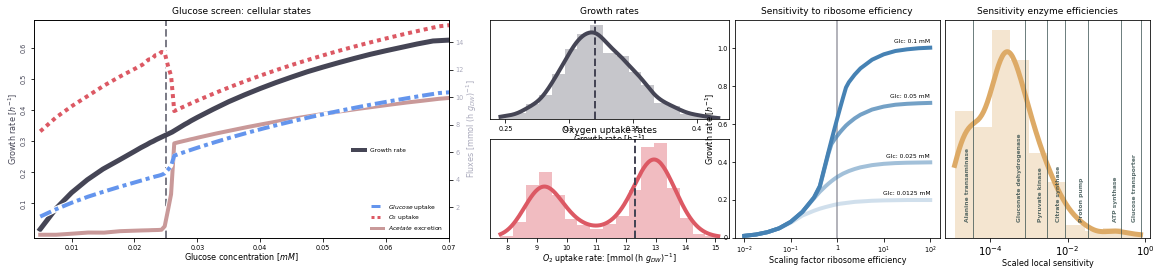

In [90]:
fig = plt.figure(figsize=(20,4),constrained_layout=True)
gs = GridSpec(2, 32, figure=fig)

ax1 = fig.add_subplot(gs[:2, :12])
ax2 = fig.add_subplot(gs[0, 13:20])
ax3 = fig.add_subplot(gs[1, 13:20])
ax4 = fig.add_subplot(gs[:2, 20:26])
ax5 = fig.add_subplot(gs[:2, 26:])

plot_glc_screen(ax=ax1,input_data=Results_glc_screen,glucose_concentrations=glcs)

plot_kapp_sampling_mu(ax=ax2,input_data=sampling_results,mu_WT=mu_WT)
plot_kapp_sampling_o2(ax=ax3,input_data=sampling_results,o2_WT=o2_WT)

plot_ribosome_efficiency_sampling(ax=ax4,input_data=Ribosome_efficiency_sampling,glucose_concentrations=Glucose_concentrations_ribosome_efficiency_sampling)


plot_local_enzyme_sensitivities(ax=ax5,input_data=Local_sensitivities_001)

#plt.tight_layout()
plt.show()


## Individual single plots

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


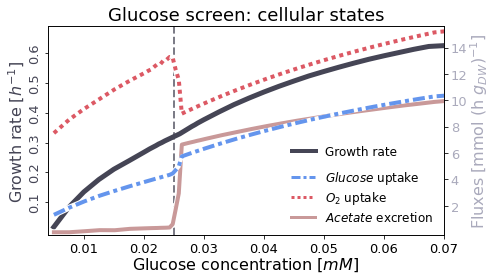

In [104]:
fig = plt.figure(figsize=(7,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_glc_screen(ax=ax,input_data=Results_glc_screen,glucose_concentrations=glcs)
plt.tight_layout()
plt.savefig('Glucose_screen_review.png',dpi=500)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


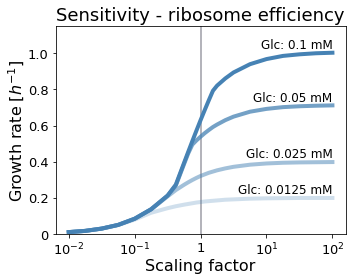

In [105]:
fig = plt.figure(figsize=(5,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_ribosome_efficiency_sampling(ax=ax,input_data=Ribosome_efficiency_sampling,glucose_concentrations=Glucose_concentrations_ribosome_efficiency_sampling)
plt.tight_layout()
plt.savefig('Ribosome_efficiency_sampling_review.png',dpi=500)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


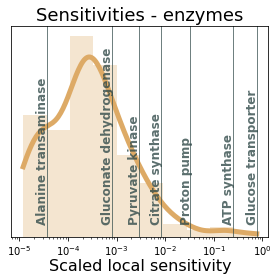

In [106]:
fig = plt.figure(figsize=(4,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_local_enzyme_sensitivities(ax=ax,input_data=Local_sensitivities_001)
plt.tight_layout()
plt.savefig('Local_sensitivities_attempt_2_review.png',dpi=500)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  import sys


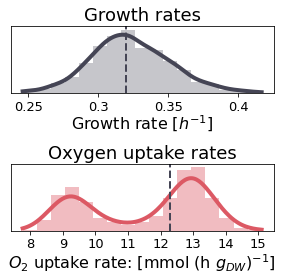

In [107]:
fig = plt.figure(figsize=(4,4),constrained_layout=True)
gs = GridSpec(2,1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
plot_kapp_sampling_mu(ax=ax1,input_data=sampling_results,mu_WT=mu_WT)
plot_kapp_sampling_o2(ax=ax2,input_data=sampling_results,o2_WT=o2_WT)
plt.tight_layout()
plt.savefig('Global_sampling_review.png',dpi=500)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  app.launch_new_instance()


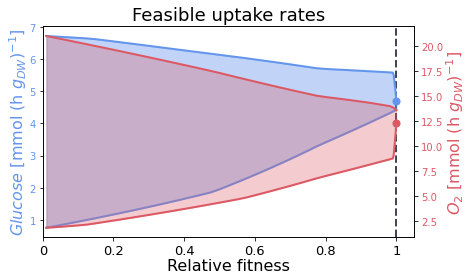

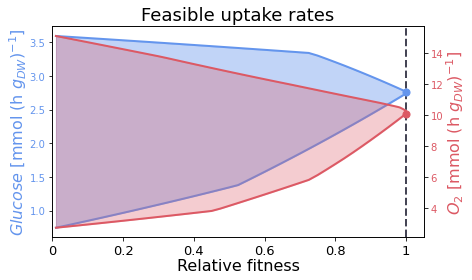

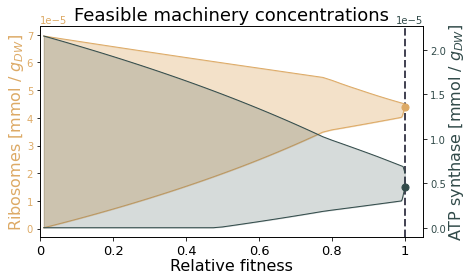

In [114]:
fig = plt.figure(figsize=(6.667,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_RVA(ax=ax,input_data=Feasible_Ranges,mu_WT=mu_WT,o2_WT=o2_WT,glc_WT=glc_WT,growth_rates=Mus_RVA)
plt.tight_layout()
plt.savefig('RVA_025.png',dpi=500)

fig = plt.figure(figsize=(6.667,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_RVA(ax=ax,input_data=Feasible_Ranges_0125,mu_WT=mu_WT_0125,o2_WT=o2_WT_0125,glc_WT=glc_WT_0125,growth_rates=Mus_RVA_0125)
plt.tight_layout()
plt.savefig('RVA_0125.png',dpi=500)

fig = plt.figure(figsize=(6.667,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_RVA_machinery(ax=ax,input_data=Feasible_Ranges,mu_WT=mu_WT,P_TA_machinery_WT=P_TA_WT,Eatp_enzyme_WT=Eatp_enzyme_WT,growth_rates=Mus_RVA)
plt.tight_layout()
plt.savefig('RVA_machinery_025.png',dpi=500)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


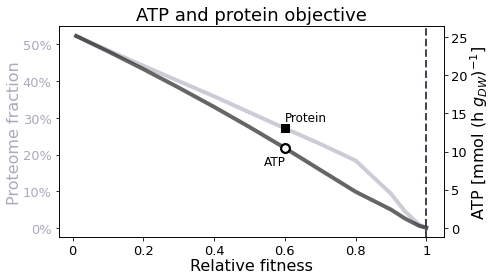

In [115]:
fig = plt.figure(figsize=(7,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_pareto_vars_vs_mu(ax=ax,input_data=Results_Pareto,mu_WT=mu_WT,add_reference_symbols=7)
plt.tight_layout()
plt.savefig('Pareto_variables_review.png',dpi=500)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


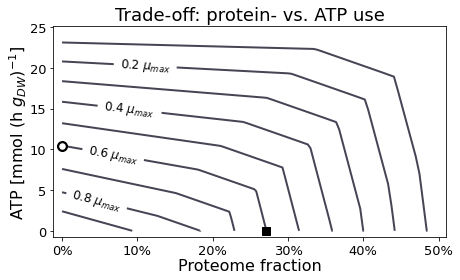

In [116]:
fig = plt.figure(figsize=(6.5,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_paretoFront_new(ax=ax,input_data=Results_Pareto,add_reference_symbols=7)
plt.tight_layout()
plt.savefig('Pareto_front_review.png',dpi=500)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  after removing the cwd from sys.path.


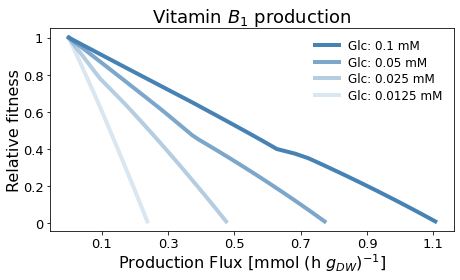

In [117]:
fig = plt.figure(figsize=(6.5,4),constrained_layout=True)
ax = fig.add_subplot(111)
plot_biotech_application(ax=ax,input_data=biotech_application_results)
plt.tight_layout()
plt.savefig('Vitamin_B1_review.png',dpi=500)
